In [128]:
import numpy as np
import pandas as pd
import random
import keras
#from sklearn.metrics import f1_score
#from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import NearestNeighbors

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.initializers import Initializer
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model


In [3]:
raw_data = pd.read_csv('./ordered_molecules_with_target.csv')

In [4]:
raw_data.head()

,time,molecule,px,py,pz,ax,ay,az,t_px,t_py,t_pz,t_ax,t_ay,t_az
0,0,1,0.27497,0.22765,0.40548,1.185458,-1.527830,-4.614324,0.27747,0.22691,0.40192,1.173813,-1.541970,-4.631340
1,0,2,2.13410,1.61428,1.62211,-4.601109,-0.659241,1.090967,2.13367,1.62206,1.61886,-4.672077,-0.805457,1.064703
2,0,3,12.05408,12.60878,2.90295,4.530882,-2.598597,2.008448,12.05656,12.60888,2.89414,4.432026,-2.609304,2.213726
3,0,4,0.85376,1.93829,4.87515,3.975239,0.917088,-2.261618,0.85851,1.94084,4.87902,3.846336,0.828634,-2.289510
4,0,5,12.70257,0.12956,6.09076,-1.861295,-0.908830,5.337542,12.70216,0.12829,6.09563,-1.790789,-0.845025,5.255177


In [31]:
def find_neighbors(t):
    df_t = raw_data.loc[raw_data['time'] == t]
    df = df_t.iloc[:,0:8]
    
    nbrs = NearestNeighbors(n_neighbors=6, algorithm='brute').fit(df)
    distances, indices = nbrs.kneighbors(df)
    
    return(df, indices)

In [103]:
def make_df(t):
    t_plus_1_df = raw_data.loc[raw_data['time']==t+1]
    t_plus_1_values = t_plus_1_df.iloc[:,2:8]
    
    li = []
    df, idx = find_neighbors(t)
    for i in range(0,idx.shape[0]):
        rows = df.loc[df['molecule'].isin(idx[i][1:]+1)]
        li.append(np.asarray(rows.iloc[:,2:8]).ravel())
    
    res = pd.DataFrame(li)
    df_made = pd.concat([res.reset_index(drop=True), t_plus_1_values.reset_index(drop=True)], axis = 1)
    return(df_made)

In [105]:
#make whole dataset
final_data = make_df(0)

for i in range(1,1999):
    df_part = make_df(i)
    final_data = pd.concat([final_data.reset_index(drop=True), df_part.reset_index(drop=True)], axis = 0)
    

In [107]:
final_data.shape

(255872, 36)

In [164]:
final_data.tail()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,px,py,pz,ax,ay,az
123,11.12416,8.49624,10.55413,0.345133,0.495141,3.834622,11.52071,10.38525,3.60727,-8.348002,...,11.89492,-0.597181,-1.916267,0.042068,10.61230,9.20293,8.07598,-1.025038,3.645025,-1.280867
124,10.23124,6.75296,7.70367,0.622598,-6.601858,0.728723,11.12416,8.49624,10.55413,0.345133,...,11.89492,-0.597181,-1.916267,0.042068,12.28148,7.63805,8.68123,3.634594,-3.766582,-2.338953
125,11.12416,8.49624,10.55413,0.345133,0.495141,3.834622,7.90987,12.05657,1.52168,4.483155,...,11.89492,-0.597181,-1.916267,0.042068,6.03300,12.81292,6.05135,2.307742,5.650190,5.404642
126,11.12416,8.49624,10.55413,0.345133,0.495141,3.834622,10.61893,9.19931,8.07314,-1.117306,...,11.89492,-0.597181,-1.916267,0.042068,9.50306,10.44102,9.99912,1.395564,-1.232665,-0.779073
127,10.23124,6.75296,7.70367,0.622598,-6.601858,0.728723,11.12416,8.49624,10.55413,0.345133,...,10.00620,1.619934,-1.090169,-0.924991,12.01283,11.18948,11.90577,-0.730089,-1.992210,-0.056095


In [114]:
x_train, x_test, y_train, y_test = train_test_split(final_data.iloc[:,0:30], 
                                                    final_data.iloc[:,30:], 
                                                    test_size = 0.3, random_state = 10)

In [155]:
#model 1
model_1 = Sequential()

model_1.add(Dense(50, input_dim=30, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer = regularizers.l2(0.1)))
model_1.add(BatchNormalization())

model_1.add(Dense(50, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer = regularizers.l2(0.1)))
model_1.add(BatchNormalization())

#model_1.add(Dense(50, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer = regularizers.l2(0.1)))
#model_1.add(BatchNormalization())

model_1.add(Dense(6, activation='linear', kernel_initializer = 'glorot_normal', kernel_regularizer = regularizers.l2(0.1)))

In [156]:
model_1.compile(loss='mean_squared_error', optimizer= "rmsprop", metrics=['mse'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min')
model_check_point = ModelCheckpoint('./DNN+KNN.h5', monitor = 'val_loss', verbose=2, save_best_only=True)
callback_list = [early_stop,model_check_point]

In [157]:
hist_1 = model_1.fit(x_train.values, y_train.values, epochs=100, batch_size=64, validation_data=(x_test, y_test), callbacks = callback_list)

Train on 179110 samples, validate on 76762 samples
Epoch 1/100
179110/179110 [==============================] - 9s 53us/step - loss: 8.5634 - mean_squared_error: 6.3749 - val_loss: 5.3757 - val_mean_squared_error: 4.8710

Epoch 00001: val_loss improved from inf to 5.37569, saving model to ./DNN+KNN.h5
Epoch 2/100
179110/179110 [==============================] - 8s 46us/step - loss: 5.2708 - mean_squared_error: 4.8481 - val_loss: 5.0915 - val_mean_squared_error: 4.7274

Epoch 00002: val_loss improved from 5.37569 to 5.09147, saving model to ./DNN+KNN.h5
Epoch 3/100
179110/179110 [==============================] - 8s 46us/step - loss: 5.1293 - mean_squared_error: 4.7893 - val_loss: 5.0232 - val_mean_squared_error: 4.7088

Epoch 00003: val_loss improved from 5.09147 to 5.02316, saving model to ./DNN+KNN.h5
Epoch 4/100
179110/179110 [==============================] - 8s 46us/step - loss: 5.0611 - mean_squared_error: 4.7609 - val_loss: 5.0271 - val_mean_squared_error: 4.7379

Epoch 00004: v

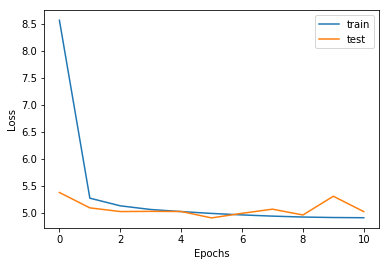

In [158]:
# plot history
plt.plot(hist_1.history['loss'], label='train')
plt.plot(hist_1.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [159]:
model = load_model('./DNN+KNN.h5')

In [160]:
y_pred = pd.DataFrame(model.predict(x_test.values))

In [161]:
mse = mean_squared_error(y_test.values, y_pred)
rmse = np.sqrt(mse)
mae_metric = mean_absolute_error(y_test.values, y_pred)
r2_error = r2_score(y_test.values, y_pred)

In [162]:
print("RMSE: ", rmse)
print("MAE: ", mae_metric)
print("R2_Score:", r2_error)

RMSE:  2.156887849372461
MAE:  1.6451626463383209
R2_Score: 0.5059388531385162


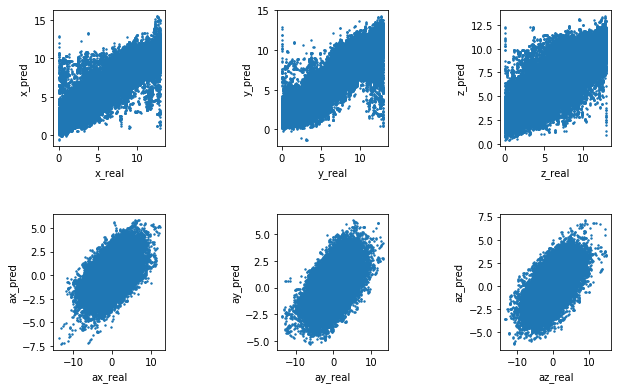

In [163]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)

ax1.scatter(y_test.values[:,0], y_pred.iloc[:,0], s= 2)
ax1.set_xlabel('x_real')
ax1.set_ylabel('x_pred')
ax2.scatter(y_test.values[:,1], y_pred.iloc[:,1], s= 2)
ax2.set_xlabel('y_real')
ax2.set_ylabel('y_pred')
ax3.scatter(y_test.values[:,2], y_pred.iloc[:,2], s= 2)
ax3.set_xlabel('z_real')
ax3.set_ylabel('z_pred')
ax4.scatter(y_test.values[:,3], y_pred.iloc[:,3], s= 2)
ax4.set_xlabel('ax_real')
ax4.set_ylabel('ax_pred')
ax5.scatter(y_test.values[:,4], y_pred.iloc[:,4], s= 2)
ax5.set_xlabel('ay_real')
ax5.set_ylabel('ay_pred')
ax6.scatter(y_test.values[:,5], y_pred.iloc[:,5], s= 2)
ax6.set_xlabel('az_real')
ax6.set_ylabel('az_pred')

plt.subplots_adjust(wspace = 1, hspace = 0.5)
plt.show()